In [77]:
import pandas as pd 
import numpy as np
import cleaning_functions as cf
import legal_functions as lf
import bail_status_dict as bs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Cross Validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# ML models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# pipelines and tuning
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
df_binary = pd.read_csv("../data/clean_merged_df.csv")
df_binary = df_binary.drop(columns = ['Unnamed: 0', 'Offence Location', 'Date', 'Proceeding Type', 'Offence Number', 'Offence'])
df_binary.shape

(3060, 26)

In [79]:
df_large = pd.read_csv("../data/very_large_df.csv")
df_large = df_large.drop(columns = ['Unnamed: 0', 'Offence Location', 'Date', 'Proceeding Type', 'Offence Number', 'Offence'])
df_large.shape

(3060, 131)

In [80]:
# clean_incustody rather than encode_incustody (get rid of rows where custody is unknown, rather than encode it)
# dropping rows witgh unknown custodial status
df_binary = cf.clean_incustody(df_binary)
df_large = cf.clean_incustody(df_large)

127 rows have been dropped
127 rows have been dropped


In [81]:
df_binary['In Custody'].value_counts()

0    2202
1     731
Name: In Custody, dtype: int64

Ensure even sample between bail and no bail

In [82]:
# Select rows where y = 1
df_y1 = df_binary[df_binary['In Custody'] == 1]

# Select 731 rows where y = 0
n = len (df_binary[df_binary['In Custody'] == 1])
df_y0_sample = df_binary [df_binary ['In Custody'] == 0] .sample (n = n, random_state = 42)

# Concatenate the two dataframes
binary_df_equal = pd.concat([df_y1, df_y0_sample])

binary_df_equal.shape

(1462, 26)

Train-test split

In [83]:
# Split the data into features (X) and target (y), and drop release type
X = binary_df_equal.drop(columns = ['In Custody', 'Release Type'], axis=1)
y = binary_df_equal['In Custody']

### XG Boost

In [84]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [85]:
# Fit the XGBoost model
xgb_model = XGBClassifier(n_estimators = 100, random_state = 42)
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.666
Precision: 0.683
Recall: 0.638


GridSearch to hypertune parameters

In [86]:
# instantiate XGB 
xgb = XGBClassifier()

# define the hyperparameter grid to search over
param_grid = {  'n_estimators' : [15, 20, 30],
                'learning_rate': [0.001, 0.01, 0.03],
                'max_depth': [6, 7, 8],
                'subsample': [0.5, 0.7, 0.9],
                'colsample_bytree': [0.3, 0.5, 0.7]
              }

grid_search = GridSearchCV(xgb, param_grid, cv=10)
grid_search.fit(X, y)

print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)

Best hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 20, 'subsample': 0.9}
Cross-validation score: 0.6697139129624453


Run model with best params

In [87]:
# initialize a XGB model with optimal params
xgb_model_final = XGBClassifier(
                    n_estimators = 300, 
                    colsample_bytree = 0.5, 
                    learning_rate = 0.01, 
                    max_depth = 7, 
                    subsample = 0.3,
                    random_state = 42)

xgb_model_final.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model_final.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.672
Precision: 0.685
Recall: 0.658


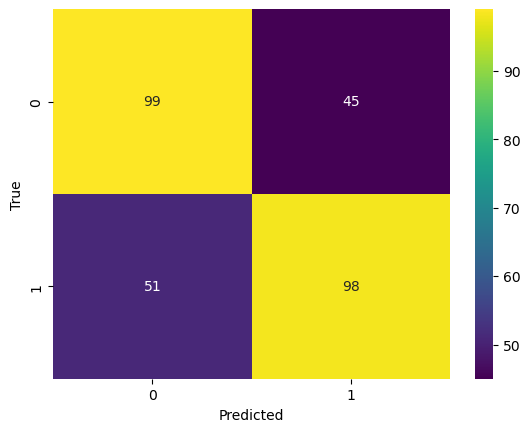

In [88]:
# Calculate the confusion matrix
confused = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot = True, fmt = 'd', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Naive Bayes

Before hyperparameter tuning

In [89]:
# Split the data into features (X) and target (y)
X = binary_df_equal.drop(columns = ['In Custody', 'Release Type'], axis=1)
y = binary_df_equal['In Custody']

In [90]:
# Create a Gaussian Naive Bayes estimator with no hyperparameters
gnb_model = GaussianNB()

# fit the model to the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.666
Precision: 0.683
Recall: 0.638


On binary-encoded df with gridsearch to hypertune parameters

In [91]:
# Create a Gaussian Naive Bayes estimator
gnb = GaussianNB()

# Define the hyperparameter grid to search over
param_grid = {
    'var_smoothing': [0.0001, 0.001, 0.01, 0.1]
}

# Create a GridSearchCV object with 5-fold cross validation
grid_search = GridSearchCV(gnb, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best hyperparameters and cross-validation score
print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)

Best hyperparameters: {'var_smoothing': 0.0001}
Cross-validation score: 0.5204895039506289


Run the model with the best hyperparameters
* select a different random state in case this helps

In [92]:
# Split the data into features (X) and target (y), and drop release type
X = binary_df_equal.drop(columns = ['In Custody', 'Release Type'], axis=1)
y = binary_df_equal['In Custody']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 52)

In [93]:
# Instantiate Gaussian Naive Bayes estimator with the best hyperparameters
gnb_model_final = GaussianNB (var_smoothing = 0.01)

# fit the model to the training data
gnb_model_final.fit(X_train, y_train)

# Predict on the test data
y_pred = gnb_model_final.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))


Accuracy: 0.485
Precision: 0.500
Recall: 0.119


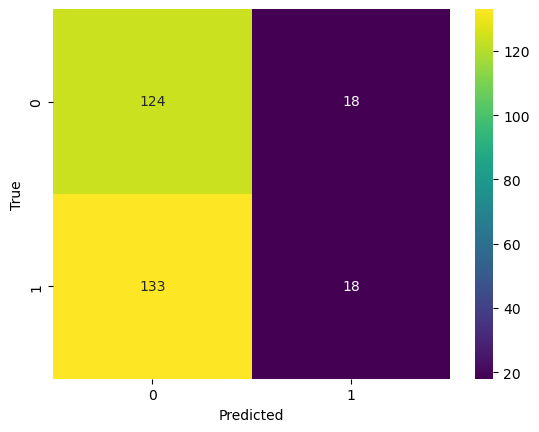

In [94]:
# Calculate the confusion matrix
confused = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot = True, fmt = 'd', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Logistic Regression
* try with large (one-hot encoded) dataset instead of binary encoded dataset

Split data evenly between bail and no bail

In [95]:
# Select rows where y = 1
df_y1 = df_large[df_large['In Custody'] == 1]

# Select 731 rows where y = 0
n = len (df_large[df_large['In Custody'] == 1])
df_y0_sample = df_large [df_large ['In Custody'] == 0] .sample (n = n, random_state = 42)

# Concatenate the two dataframes
large_df_equal = pd.concat([df_y1, df_y0_sample])

large_df_equal.shape

(1462, 131)

In [96]:
# Split the data into features (X) and target (y), and drop release type
X = large_df_equal.drop(columns = ['In Custody', 'Release Type'], axis=1)
y = large_df_equal['In Custody']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 52)

Calculate pre-tuning results

In [97]:
# Instantiate a logistic regression model with no hyperparameters
lr_model_final = LogisticRegression(max_iter = 1000)

# Fit the model on the training set
lr_model_final.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model_final.predict(X_test)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.648
Precision: 0.667
Recall: 0.636


In [98]:
'''# Define the hyperparameter grid to search over
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.1, 1, 10, 20],
              'solver': ['liblinear', 'saga'],
              'max_iter' : [10000, 100000, 500000]
             }

# Instantiate a logistic regression model
lr = LogisticRegression()

# Create a GridSearchCV object with 5-fold cross validation
grid_search = GridSearchCV (lr, param_grid, cv = 5)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best hyperparameters and cross-validation score
print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)
'''

"# Define the hyperparameter grid to search over\nparam_grid = {'penalty': ['l1', 'l2'],\n              'C': [0.1, 1, 10, 20],\n              'solver': ['liblinear', 'saga'],\n              'max_iter' : [10000, 100000, 500000]\n             }\n\n# Instantiate a logistic regression model\nlr = LogisticRegression()\n\n# Create a GridSearchCV object with 5-fold cross validation\ngrid_search = GridSearchCV (lr, param_grid, cv = 5)\n\n# Fit the grid search to the data\ngrid_search.fit(X, y)\n\n# Print the best hyperparameters and cross-validation score\nprint('Best hyperparameters:', grid_search.best_params_)\nprint('Cross-validation score:', grid_search.best_score_)\n"

Run Logistic Regression model with the best hyperparameters and use to make predictions

In [99]:
# Instantiate a logistic regression model with the best hyperparameters
lr_model_final = LogisticRegression(C = 20,
                                    penalty = 'l1',
                                    solver = 'liblinear',
                                    max_iter = 10000 )

# Fit the model on the training set
lr_model_final.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model_final.predict(X_test)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.648
Precision: 0.674
Recall: 0.616


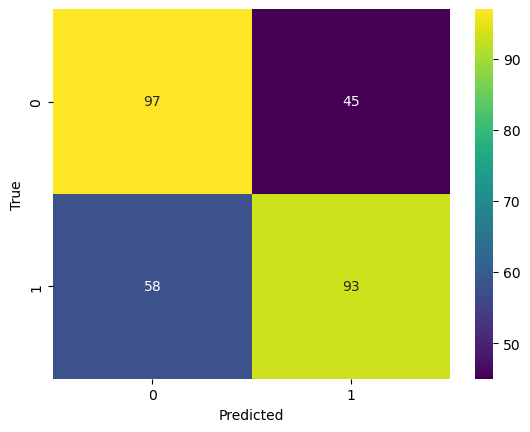

In [100]:
# Calculate the confusion matrix
confused = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot = True, fmt = 'd', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest
* Again using large_df, made equal between bail and no bail

In [101]:
# Split the data into features (X) and target (y), and drop release type
X = large_df_equal.drop(columns = ['In Custody', 'Release Type'], axis=1)
y = large_df_equal['In Custody']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 52)

Get pre-tuning results

In [102]:
# Instantiate Random Forest model with no hyperparameters
rf_model = RandomForestClassifier()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Fit the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.700
Precision: 0.710
Recall: 0.691


Gridsearch with 5-fold cross validation to get best hyperparametrs

In [103]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [70, 80, 100, 120],
    'max_depth': [10, 15, 20],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest object
rf_model = RandomForestClassifier(random_state = 42)

# Create a GridSearchCV object with 5-fold cross validation
grid_search = GridSearchCV(rf_model, 
                           param_grid, 
                           cv = 5, 
                           n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best hyperparameters and cross-validation score
print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)

Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}
Cross-validation score: 0.6682874374678573


Instantiate Random Forest model with the best hyperparameters and make predictions

In [104]:
# Instantiate Random Forest model with the best hyperparameters
rf_model_final = RandomForestClassifier(n_estimators = 70,
                                    max_depth = 15,
                                    min_samples_split = 5,
                                    min_samples_leaf = 1
                                    )

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Fit the model on the training set
rf_model_final.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model_final.predict(X_test)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.676
Precision: 0.680
Recall: 0.685


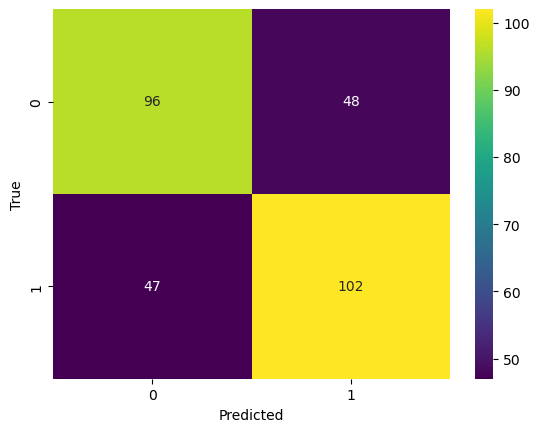

In [105]:
# Calculate the confusion matrix
confused = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot = True, fmt = 'd', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Ensemble Models - Voting Classifier

In [106]:
# define the individual models
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(C=0.1, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)

# create a voting classifier with the individual models
voting_classifier = VotingClassifier(
    estimators=[('nb', nb), ('rf', rf), ('lr', lr), ('xgb', xgb)],
    voting='hard'
)

# fit the voting classifier to the training data
voting_classifier.fit(X_train, y_train)

# predict on the test data
y_pred = voting_classifier.predict(X_test)

# calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print the results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

c:\Users\emily\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.652
Precision: 0.720
Recall: 0.517
